# 🏦 QUANTUM FINANCE - Trading com Reinforcement Learning
## 🎓 Versão Educativa para Estudantes Iniciantes

---

**👥 Projeto Integrado - Equipe de Estudantes**  
**🎯 Objetivo:** Aprender Reinforcement Learning aplicado ao mercado financeiro  
**📊 Ativos:** Vale (VALE3), Petrobras (PETR4), BRF (BRFS3)  
**💰 Capital Inicial:** R$ 10.000  

---

### 📚 **O que vamos aprender hoje?**

Vamos criar um "robô trader" que aprende a investir sozinho! Como se fosse um cachorro aprendendo truques, nosso agente vai:

1. **🧠 Observar** o mercado (preços, tendências)
2. **🎯 Decidir** o que fazer (comprar, vender, manter)
3. **💰 Receber recompensa** se ganhou ou perdeu dinheiro
4. **📈 Aprender** com os erros e acertos

É como ensinar alguém a jogar videogame: no início erra muito, mas depois fica expert!

## 🎮 Configuração Principal - FÁCIL de Entender e Modificar

In [1]:
# 🚀 FORÇAR USO DE CPU (Evitar erros de CUDA)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Usar apenas CPU

In [2]:
# =============================================================================
# 🎮 CONFIGURAÇÃO PRINCIPAL - FÁCIL DE ENTENDER E MODIFICAR
# =============================================================================

print("🏦 Configurando o Quantum Finance...")
print("=" * 60)

# 📊 Parâmetros do Mercado (VOCÊ PODE MODIFICAR!)
CAPITAL_INICIAL = 10000        # R$ 10.000 para começar
ACOES_POR_OPERACAO = 10        # Sempre comprar/vender 10 ações por vez
PERIODO_INICIO = '2018-01-01'  # Data de início dos dados
PERIODO_FIM = '2025-12-31'     # Data final dos dados
PERIODO_TREINO = '2022-01-01'  # Quando dividir treino/teste
PERIODO_TESTE = '2023-01-01'   # Quando começar a testar

# 🎓 Parâmetros do Agente (Simples para iniciantes)
EPISODIOS_TREINO = 500          # Quantas vezes o agente vai "praticar"
EXPLORACAO_INICIAL = 1.0       # 100% exploração no início (agente curioso)
EXPLORACAO_FINAL = 0.01         # 1% exploração no final (agente experiente)
TAXA_APRENDIZADO = 0.0005        # Quão devagar o agente aprende (0.01 = bem devagar)

# 🏆 Ações Possíveis (Simplificado)
ACOES_POSSIVEIS = [
    "🔄 MANTER (não fazer nada)",
    "💰 COMPRAR Vale",
    "💰 COMPRAR Petrobras", 
    "💰 COMPRAR BRF",
    "💸 VENDER Vale",
    "💸 VENDER Petrobras",
    "💸 VENDER BRF"
]

print(f"💰 Capital inicial: R$ {CAPITAL_INICIAL:,}")
print(f"📈 Ações por operação: {ACOES_POR_OPERACAO}")
print(f"🎓 Episódios de treino: {EPISODIOS_TREINO}")
print(f"🎯 Taxa de aprendizado: {TAXA_APRENDIZADO}")
print(f"📅 Período dados: {PERIODO_INICIO} a {PERIODO_FIM}")
print(f"🔧 Divisão: Treino até {PERIODO_TREINO}, Teste após {PERIODO_TESTE}")
print("✅ Configuração concluída!")

🏦 Configurando o Quantum Finance...
💰 Capital inicial: R$ 10,000
📈 Ações por operação: 10
🎓 Episódios de treino: 500
🎯 Taxa de aprendizado: 0.0005
📅 Período dados: 2018-01-01 a 2025-12-31
🔧 Divisão: Treino até 2022-01-01, Teste após 2023-01-01
✅ Configuração concluída!


## 📦 Importando as Ferramentas (Bibliotecas)

In [3]:
# 📦 Importando todas as ferramentas que vamos usar
print("📦 Carregando ferramentas...")

import numpy as np              # Para cálculos matemáticos
import pandas as pd             # Para trabalhar com dados
import matplotlib.pyplot as plt # Para fazer gráficos
import yfinance as yf          # Para baixar dados do mercado
import tensorflow as tf        # Para criar nossa "inteligência artificial"
from tensorflow import keras
from tensorflow.keras import layers
import random                  # Para aleatoriedade
from collections import deque  # Para memória do agente
import warnings
warnings.filterwarnings('ignore')  # Esconder avisos chatos

# Configurar TensorFlow para usar apenas CPU (evitar erros)
tf.config.set_visible_devices([], 'GPU')

# Configurar estilo dos gráficos
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Todas as ferramentas carregadas!")
print(f"🧠 TensorFlow versão: {tf.__version__}")
print(f"📊 Pandas versão: {pd.__version__}")
print(f"🔢 NumPy versão: {np.__version__}")

📦 Carregando ferramentas...


2025-11-02 22:35:43.900768: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-02 22:35:43.902991: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-02 22:35:44.254118: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-02 22:35:46.625335: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

✅ Todas as ferramentas carregadas!
🧠 TensorFlow versão: 2.20.0
📊 Pandas versão: 2.3.2
🔢 NumPy versão: 2.1.3


2025-11-02 22:35:47.590561: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
# 📊 Baixando e Preparando os Dados do Mercado
print("📡 Baixando dados das ações...")
print("=" * 50)

# 📋 Definir nossas empresas favoritas
tickers = ['VALE3.SA', 'PETR4.SA', 'BRFS3.SA']  # Códigos da B3
nomes_acoes = ['Vale', 'Petrobras', 'BRF']        # Nomes mais amigáveis

print("🏢 Empresas escolhidas:")
for ticker, nome in zip(tickers, nomes_acoes):
    print(f"   📈 {nome}: {ticker}")

# 🌐 Baixar dados históricos do Yahoo Finance
print(f"\n📅 Baixando dados de {PERIODO_INICIO} até {PERIODO_FIM}...")
dados_acoes = {}

for ticker, nome in zip(tickers, nomes_acoes):
    print(f"   ⏳ Baixando {nome}...", end=" ")
    try:
        dados_acoes[ticker] = yf.download(ticker, 
                                         start=PERIODO_INICIO, 
                                         end=PERIODO_FIM, 
                                         progress=False)
        print(f"✅ OK ({len(dados_acoes[ticker])} dias)")
    except Exception as e:
        print(f"❌ Erro: {e}")

# 🧮 Função para calcular OBV (On-Balance Volume)
def calcular_obv(precos, volumes):
    """
    📊 Calcula o On-Balance Volume (OBV)
    
    O OBV é como um "medidor de força" da ação:
    - Se preço sobe E volume alto = Muita gente comprando (forte)
    - Se preço desce E volume alto = Muita gente vendendo (fraco)
    """
    # Garantir que são Series simples (sem complicações)
    if isinstance(precos, pd.DataFrame):
        precos = precos.iloc[:, 0]
    if isinstance(volumes, pd.DataFrame):
        volumes = volumes.iloc[:, 0]
    
    precos = pd.Series(precos) if not isinstance(precos, pd.Series) else precos
    volumes = pd.Series(volumes) if not isinstance(volumes, pd.Series) else volumes
    
    obv = pd.Series(0.0, index=precos.index)
    obv.iloc[0] = volumes.iloc[0]  # Começar com o primeiro volume
    
    # Calcular OBV: se preço subiu, soma volume; se desceu, subtrai
    for i in range(1, len(precos)):
        if precos.iloc[i] > precos.iloc[i-1]:      # Preço subiu
            obv.iloc[i] = obv.iloc[i-1] + volumes.iloc[i]
        elif precos.iloc[i] < precos.iloc[i-1]:    # Preço desceu  
            obv.iloc[i] = obv.iloc[i-1] - volumes.iloc[i]
        else:                                       # Preço igual
            obv.iloc[i] = obv.iloc[i-1]
    
    return obv

# 🔧 Preparar dados consolidados com indicadores técnicos
print("\n🔧 Calculando indicadores técnicos...")
dados_completos = {}

for ticker, nome in zip(tickers, nomes_acoes):
    if ticker in dados_acoes:
        print(f"   ⚙️ Processando {nome}...", end=" ")
        
        df_temp = pd.DataFrame(index=dados_acoes[ticker].index)
        
        # 💰 Preço de fechamento (o mais importante!)
        df_temp[f'{nome}_preco'] = dados_acoes[ticker]['Close']
        
        # 📦 Volume negociado
        df_temp[f'{nome}_volume'] = dados_acoes[ticker]['Volume']
        
        # 📈 Médias móveis (tendências)
        df_temp[f'{nome}_mm8'] = dados_acoes[ticker]['Close'].rolling(window=8).mean()    # Curto prazo
        df_temp[f'{nome}_mm20'] = dados_acoes[ticker]['Close'].rolling(window=20).mean()  # Médio prazo
        df_temp[f'{nome}_mm200'] = dados_acoes[ticker]['Close'].rolling(window=200).mean() # Longo prazo
        
        # 📊 OBV (força do movimento)
        df_temp[f'{nome}_obv'] = calcular_obv(
            dados_acoes[ticker]['Close'],
            dados_acoes[ticker]['Volume']
        )
        
        dados_completos[nome] = df_temp
        print("✅")

# 🗂️ Combinar todos os dados em uma planilha gigante
print("\n🗂️ Consolidando todos os dados...")
dados_mercado = pd.DataFrame(index=dados_acoes[tickers[0]].index)

for nome in nomes_acoes:
    if nome in dados_completos:
        dados_mercado = dados_mercado.join(dados_completos[nome])

# 🧹 Limpar dados (remover linhas com valores faltando)
dados_antes = len(dados_mercado)
dados_mercado = dados_mercado.dropna()
dados_depois = len(dados_mercado)

print(f"📊 Dados consolidados:")
print(f"   📅 Período: {dados_mercado.index[0].date()} a {dados_mercado.index[-1].date()}")
print(f"   📈 Total de dias: {dados_depois} (removidos {dados_antes - dados_depois} dias incompletos)")
print(f"   📋 Colunas: {dados_mercado.shape[1]} indicadores")
print("✅ Dados prontos para o treinamento!")

📡 Baixando dados das ações...
🏢 Empresas escolhidas:
   📈 Vale: VALE3.SA
   📈 Petrobras: PETR4.SA
   📈 BRF: BRFS3.SA

📅 Baixando dados de 2018-01-01 até 2025-12-31...
   ⏳ Baixando Vale... ✅ OK (1949 dias)
   ⏳ Baixando Petrobras... ✅ OK (1949 dias)
   ⏳ Baixando Petrobras... ✅ OK (1949 dias)
   ⏳ Baixando BRF... ✅ OK (1949 dias)
   ⏳ Baixando BRF... ✅ OK (1920 dias)

🔧 Calculando indicadores técnicos...
   ⚙️ Processando Vale... ✅
   ⚙️ Processando Petrobras... ✅
   ⚙️ Processando BRF... ✅

🗂️ Consolidando todos os dados...
📊 Dados consolidados:
   📅 Período: 2018-10-18 a 2025-09-22
   📈 Total de dias: 1721 (removidos 228 dias incompletos)
   📋 Colunas: 18 indicadores
✅ Dados prontos para o treinamento!
✅ OK (1920 dias)

🔧 Calculando indicadores técnicos...
   ⚙️ Processando Vale... ✅
   ⚙️ Processando Petrobras... ✅
   ⚙️ Processando BRF... ✅

🗂️ Consolidando todos os dados...
📊 Dados consolidados:
   📅 Período: 2018-10-18 a 2025-09-22
   📈 Total de dias: 1721 (removidos 228 dias inc

✂️ Dividindo dados em treino e teste...
📚 DADOS DE TREINO (onde o agente vai aprender):
   📅 Período: 2018-10-18 a 2021-12-30
   📈 Total de dias: 790

🧪 DADOS DE TESTE (onde vamos avaliar se aprendeu):
   📅 Período: 2022-01-03 a 2022-12-29
   📈 Total de dias: 250

📊 Criando visualização dos dados...


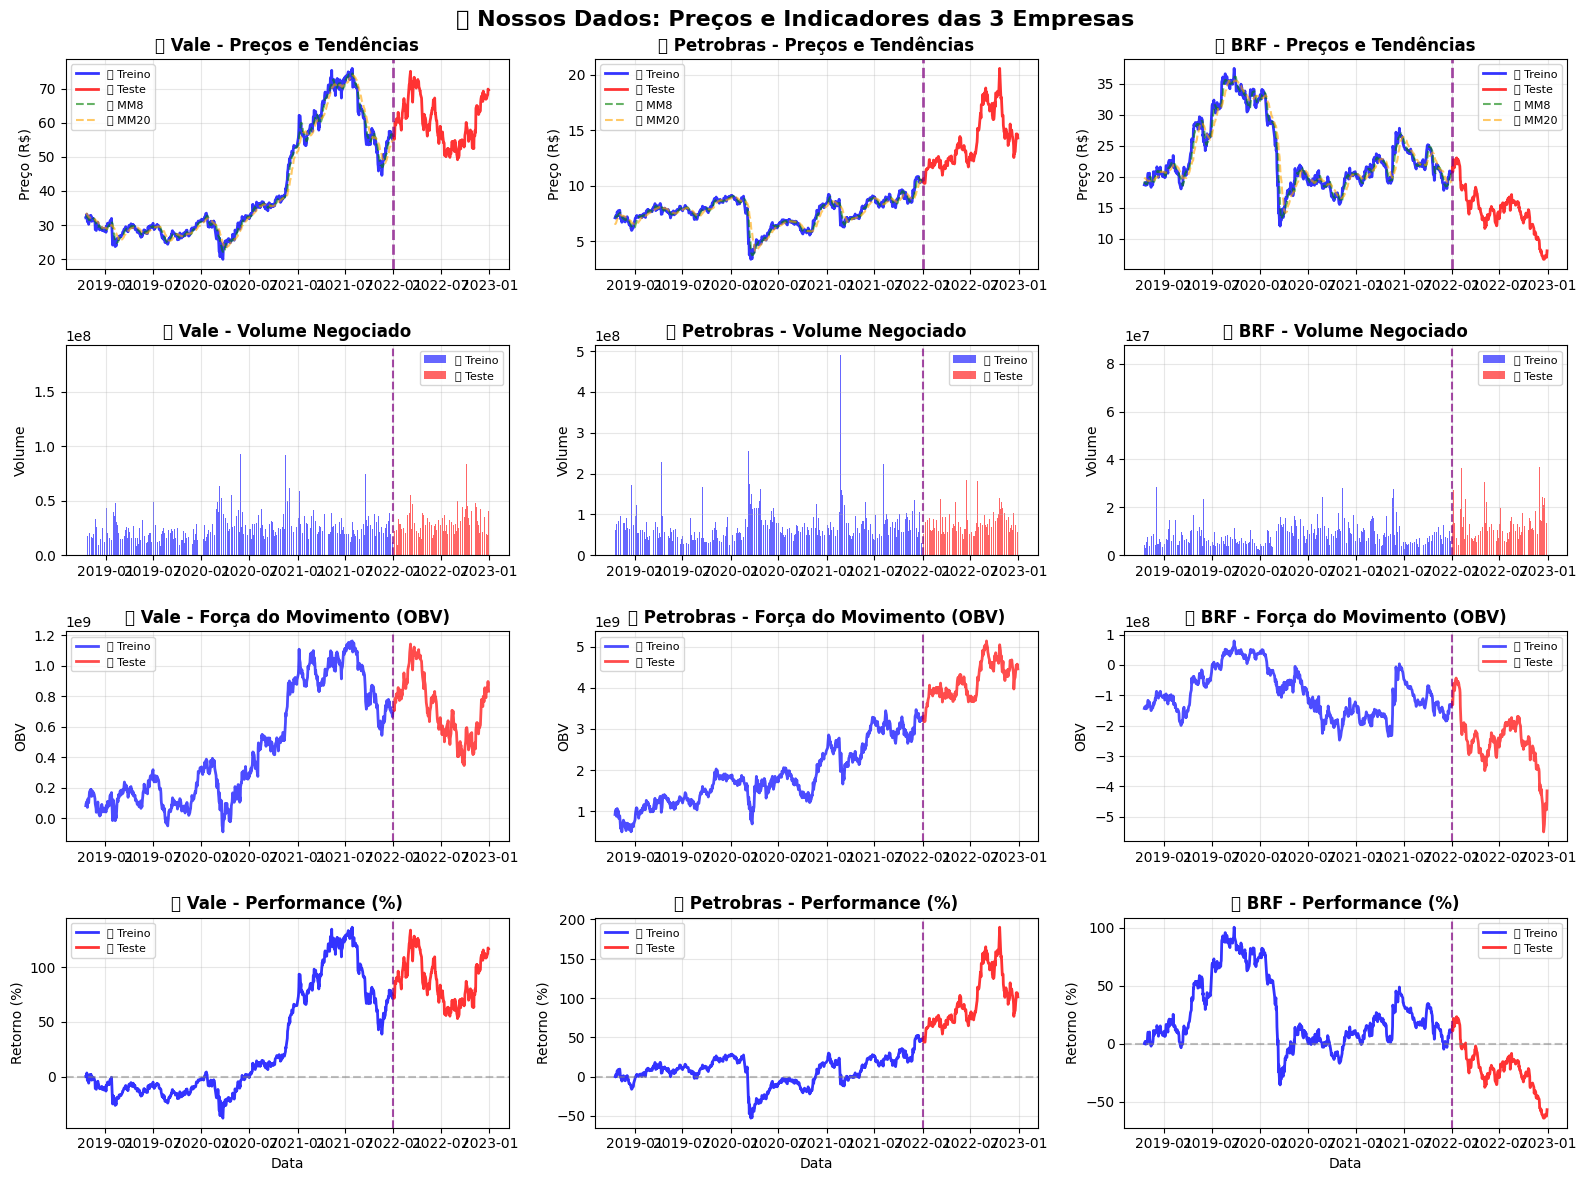

✅ Visualização concluída! Agora vamos criar nosso agente inteligente...


In [5]:
# ✂️ Dividindo os Dados: Treino vs Teste
print("✂️ Dividindo dados em treino e teste...")
print("=" * 50)

# 📅 Usar nossas configurações definidas anteriormente
data_corte_treino = PERIODO_TREINO  # '2023-01-01' 
data_corte_teste = PERIODO_TESTE    # '2024-01-01'

# ✂️ Fazer a divisão
dados_treino = dados_mercado[dados_mercado.index < data_corte_treino].copy()
dados_teste = dados_mercado[(dados_mercado.index >= data_corte_treino) & (dados_mercado.index < data_corte_teste)].copy()

# 📊 Mostrar estatísticas
print("📚 DADOS DE TREINO (onde o agente vai aprender):")
print(f"   📅 Período: {dados_treino.index[0].date()} a {dados_treino.index[-1].date()}")
print(f"   📈 Total de dias: {len(dados_treino)}")

print("\n🧪 DADOS DE TESTE (onde vamos avaliar se aprendeu):")
print(f"   📅 Período: {dados_teste.index[0].date()} a {dados_teste.index[-1].date()}")
print(f"   📈 Total de dias: {len(dados_teste)}")

# 🎯 Verificar se temos dados suficientes
if len(dados_treino) < 100:
    print("⚠️ ATENÇÃO: Poucos dados de treino! Pode ser difícil aprender.")
if len(dados_teste) < 50:
    print("⚠️ ATENÇÃO: Poucos dados de teste! Avaliação pode não ser confiável.")

# 📊 Visualizar os dados de forma educativa
print("\n📊 Criando visualização dos dados...")
fig, axes = plt.subplots(4, 3, figsize=(16, 12))
fig.suptitle('📈 Nossos Dados: Preços e Indicadores das 3 Empresas', fontsize=16, fontweight='bold')

for idx, nome in enumerate(nomes_acoes):
    # 💰 Gráfico 1: Preços e médias móveis
    col_preco = f'{nome}_preco'
    if col_preco in dados_treino.columns:
        # Preços principais
        axes[0, idx].plot(dados_treino.index, dados_treino[col_preco], 
                         label='📚 Treino', alpha=0.8, linewidth=2, color='blue')
        axes[0, idx].plot(dados_teste.index, dados_teste[col_preco], 
                         label='🧪 Teste', alpha=0.8, linewidth=2, color='red')
        
        # Médias móveis (tendências)
        axes[0, idx].plot(dados_treino.index, dados_treino[f'{nome}_mm8'], 
                         label='📈 MM8', alpha=0.6, linestyle='--', color='green')
        axes[0, idx].plot(dados_treino.index, dados_treino[f'{nome}_mm20'], 
                         label='📈 MM20', alpha=0.6, linestyle='--', color='orange')
        
        # Linha de divisão
        axes[0, idx].axvline(x=pd.Timestamp(data_corte_treino), color='purple', 
                            linestyle='--', alpha=0.7, linewidth=2)
        
        axes[0, idx].set_title(f'💰 {nome} - Preços e Tendências', fontweight='bold')
        axes[0, idx].set_ylabel('Preço (R$)')
        axes[0, idx].legend(fontsize=8)
        axes[0, idx].grid(True, alpha=0.3)
    
    # 📦 Gráfico 2: Volume de negociação
    col_volume = f'{nome}_volume'
    if col_volume in dados_treino.columns:
        axes[1, idx].bar(dados_treino.index, dados_treino[col_volume], 
                        alpha=0.6, width=1, label='📚 Treino', color='blue')
        axes[1, idx].bar(dados_teste.index, dados_teste[col_volume], 
                        alpha=0.6, width=1, label='🧪 Teste', color='red')
        axes[1, idx].axvline(x=pd.Timestamp(data_corte_treino), color='purple', 
                            linestyle='--', alpha=0.7)
        axes[1, idx].set_title(f'📦 {nome} - Volume Negociado', fontweight='bold')
        axes[1, idx].set_ylabel('Volume')
        axes[1, idx].legend(fontsize=8)
        axes[1, idx].grid(True, alpha=0.3)
    
    # 📊 Gráfico 3: OBV (força do movimento)
    col_obv = f'{nome}_obv'
    if col_obv in dados_treino.columns:
        axes[2, idx].plot(dados_treino.index, dados_treino[col_obv], 
                         label='📚 Treino', alpha=0.7, linewidth=2, color='blue')
        axes[2, idx].plot(dados_teste.index, dados_teste[col_obv], 
                         label='🧪 Teste', alpha=0.7, linewidth=2, color='red')
        axes[2, idx].axvline(x=pd.Timestamp(data_corte_treino), color='purple', 
                            linestyle='--', alpha=0.7)
        axes[2, idx].set_title(f'📊 {nome} - Força do Movimento (OBV)', fontweight='bold')
        axes[2, idx].set_ylabel('OBV')
        axes[2, idx].legend(fontsize=8)
        axes[2, idx].grid(True, alpha=0.3)
    
    # 📈 Gráfico 4: Performance normalizada (para comparar)
    if col_preco in dados_treino.columns:
        # Normalizar pelo primeiro valor (mostra % de crescimento)
        preco_inicial = dados_treino[col_preco].iloc[0]
        treino_norm = (dados_treino[col_preco] / preco_inicial - 1) * 100
        teste_norm = (dados_teste[col_preco] / preco_inicial - 1) * 100
        
        axes[3, idx].plot(dados_treino.index, treino_norm, 
                         label='📚 Treino', alpha=0.8, linewidth=2, color='blue')
        axes[3, idx].plot(dados_teste.index, teste_norm, 
                         label='🧪 Teste', alpha=0.8, linewidth=2, color='red')
        axes[3, idx].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        axes[3, idx].axvline(x=pd.Timestamp(data_corte_treino), color='purple', 
                            linestyle='--', alpha=0.7)
        axes[3, idx].set_title(f'🎯 {nome} - Performance (%)', fontweight='bold')
        axes[3, idx].set_ylabel('Retorno (%)')
        axes[3, idx].set_xlabel('Data')
        axes[3, idx].legend(fontsize=8)
        axes[3, idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print("✅ Visualização concluída! Agora vamos criar nosso agente inteligente...")

## 🎮 Criando o "Ambiente de Trading" - Onde nosso agente vai "jogar"

In [6]:
# 🎮 Classe do Ambiente de Trading (Versão Educativa Simplificada)

class AmbienteTradingSimples:
    """
    🎯 AMBIENTE DE TRADING SIMPLIFICADO PARA ESTUDANTES
    
    Imagine que este é um "jogo de investimentos" onde:
    
    🧠 ESTADO (o que o agente vê):
       - Quanto dinheiro temos em caixa
       - Quantas ações de cada empresa temos  
       - Se os preços estão subindo ou descendo (tendência)
       Total: 7 informações simples
    
    🎯 AÇÕES (o que o agente pode fazer):
       0 = 🔄 MANTER (não fazer nada)
       1 = 💰 COMPRAR Vale
       2 = 💰 COMPRAR Petrobras  
       3 = 💰 COMPRAR BRF
       4 = 💸 VENDER Vale
       5 = 💸 VENDER Petrobras
       6 = 💸 VENDER BRF
    
    🎁 RECOMPENSA (como sabemos se foi boa ideia):
       - Se valor do portfólio subiu = RECOMPENSA POSITIVA! 😊
       - Se valor do portfólio desceu = RECOMPENSA NEGATIVA! 😞
    """
    
    def __init__(self, dados_mercado, capital_inicial=10000, acoes_por_operacao=10):
        print("🏗️ Criando ambiente de trading simplificado...")
        
        # 📊 Configurações básicas
        self.dados_mercado = dados_mercado.reset_index(drop=True)
        self.capital_inicial = capital_inicial
        self.acoes_por_operacao = acoes_por_operacao  # Sempre comprar/vender esta quantidade
        self.nomes_acoes = ['Vale', 'Petrobras', 'BRF']
        
        # 🎯 Definir espaços de ação e estado
        self.action_space = 7  # 7 ações possíveis (0-6)
        self.state_size = 7    # 7 dimensões do estado
        
        # 🔄 Variáveis que mudam durante o jogo
        self.dia_atual = 0
        self.saldo = capital_inicial
        self.acoes_possuidas = [0, 0, 0]  # [Vale, Petrobras, BRF]
        self.historico_portfolio = []
        
        # 📈 Para calcular tendências simples
        self.historico_precos = {nome: [] for nome in self.nomes_acoes}
        
        print(f"✅ Ambiente criado!")
        print(f"   💰 Capital: R$ {capital_inicial:,}")
        print(f"   📊 Ações por operação: {acoes_por_operacao}")
        print(f"   📅 Dias disponíveis: {len(self.dados_mercado)}")
        print(f"   🎯 Ações possíveis: {self.action_space}")
        print(f"   🧠 Tamanho do estado: {self.state_size}")
    
    def reset(self):
        """🔄 Reiniciar o jogo (começar um novo episódio)"""
        self.dia_atual = 0
        self.saldo = self.capital_inicial
        self.acoes_possuidas = [0, 0, 0]
        self.historico_portfolio = []
        self.historico_precos = {nome: [] for nome in self.nomes_acoes}
        
        # Calcular estado inicial
        estado_inicial = self._calcular_estado_simples()
        return estado_inicial
    
    def _obter_dados_dia(self):
        """📅 Pegar os dados do mercado para o dia atual"""
        if self.dia_atual >= len(self.dados_mercado):
            return None
        return self.dados_mercado.iloc[self.dia_atual]
    
    def _obter_precos_dia(self):
        """💰 Pegar apenas os preços das ações para hoje"""
        dados_hoje = self._obter_dados_dia()
        if dados_hoje is None:
            return [0, 0, 0]
        
        precos = []
        for nome in self.nomes_acoes:
            preco = dados_hoje[f'{nome}_preco']
            precos.append(preco)
        return precos
    
    def _calcular_valor_portfolio(self):
        """💎 Calcular valor total do nosso portfólio"""
        precos_hoje = self._obter_precos_dia()
        
        # Valor das ações que possuímos
        valor_acoes = sum(qtd * preco for qtd, preco in zip(self.acoes_possuidas, precos_hoje))
        
        # Valor total = dinheiro em caixa + valor das ações
        valor_total = self.saldo + valor_acoes
        return valor_total
    
    def _calcular_estado_simples(self):
        """
        🧠 ESTADO SIMPLIFICADO PARA INICIANTES
        
        Em vez de 22 dimensões complexas, vamos usar apenas o essencial:
        [0] Quanto dinheiro temos (normalizado)
        [1] Quantas ações Vale temos 
        [2] Quantas ações Petrobras temos
        [3] Quantas ações BRF temos  
        [4] Vale: subindo(+1), estável(0), descendo(-1)?
        [5] Petrobras: subindo(+1), estável(0), descendo(-1)?
        [6] BRF: subindo(+1), estável(0), descendo(-1)?
        """
        dados_hoje = self._obter_dados_dia()
        if dados_hoje is None:
            return np.zeros(7)
        
        # 1. Saldo normalizado (1.0 = capital inicial)
        saldo_normalizado = self.saldo / self.capital_inicial
        
        # 2. Quantidades de ações (normalizado por 100)
        vale_acoes = self.acoes_possuidas[0] / 100
        petro_acoes = self.acoes_possuidas[1] / 100  
        brf_acoes = self.acoes_possuidas[2] / 100
        
        # 3. Tendências simples: comparar com média dos últimos dias
        tendencias = []
        for nome in self.nomes_acoes:
            preco_hoje = dados_hoje[f'{nome}_preco']
            
            # Usar média móvel de 8 dias como referência
            media_referencia = dados_hoje[f'{nome}_mm8']
            
            if pd.notna(media_referencia) and media_referencia > 0:
                diferenca_percentual = (preco_hoje - media_referencia) / media_referencia
                
                # Simplificar: -1 (descendo), 0 (estável), +1 (subindo)
                if diferenca_percentual > 0.02:      # Subindo mais que 2%
                    tendencia_simples = 1
                elif diferenca_percentual < -0.02:   # Descendo mais que 2%
                    tendencia_simples = -1
                else:                                # Estável
                    tendencia_simples = 0
            else:
                tendencia_simples = 0
            
            tendencias.append(tendencia_simples)
        
        # Estado final: 7 dimensões fáceis de entender
        estado = [
            saldo_normalizado,  # 0: Dinheiro disponível
            vale_acoes,         # 1: Ações da Vale  
            petro_acoes,        # 2: Ações da Petrobras
            brf_acoes,          # 3: Ações da BRF
            tendencias[0],      # 4: Vale subindo/descendo?
            tendencias[1],      # 5: Petrobras subindo/descendo?
            tendencias[2]       # 6: BRF subindo/descendo?
        ]
        
        return np.array(estado, dtype=np.float32)
    
    def _calcular_recompensa_simples(self, valor_antes, valor_depois, acao):
        """
        🎯 FUNÇÃO DE RECOMPENSA SIMPLIFICADA
        
        Para iniciantes, vamos usar uma lógica bem simples:
        - Se o valor do portfólio subiu: RECOMPENSA POSITIVA! 😊
        - Se o valor do portfólio desceu: RECOMPENSA NEGATIVA! 😞
        - Pequena penalidade por fazer transações (simula taxas)
        """
        
        # 1. Calcular a diferença no valor do portfólio
        mudanca_valor = valor_depois - valor_antes
        
        # 2. Converter para percentual (mais fácil de entender)  
        mudanca_percentual = (mudanca_valor / valor_antes) * 100 if valor_antes > 0 else 0
        
        # 3. Recompensa base = mudança percentual
        recompensa = mudanca_percentual
        
        # 4. Pequena taxa por transação (apenas se não for "manter")
        if acao != 0:  # Se não for "manter"
            taxa_transacao = 0.1  # 0.1% de taxa
            recompensa -= taxa_transacao
        
        # 5. Bônus por ganhar dinheiro (facilitar aprendizado)
        if mudanca_valor > 0:
            bonus = 0.5  # Pequeno bônus
            recompensa += bonus
        
        return recompensa
    
    def _executar_acao_simples(self, action):
        """
        🎯 EXECUTAR AÇÃO SIMPLES
        
        Ações possíveis:
        0 = Manter (não fazer nada)
        1 = Comprar Vale      4 = Vender Vale
        2 = Comprar Petrobras 5 = Vender Petrobras  
        3 = Comprar BRF       6 = Vender BRF
        """
        precos_hoje = self._obter_precos_dia()
        
        if action == 0:  # 🔄 MANTER
            pass  # Não fazer nada
            
        elif action in [1, 2, 3]:  # 💰 COMPRAR
            indice_acao = action - 1  # 1->0, 2->1, 3->2
            preco = precos_hoje[indice_acao]
            
            # Custo total com taxa de 0.1%
            custo_total = self.acoes_por_operacao * preco * 1.001
            
            # Só comprar se temos dinheiro suficiente
            if self.saldo >= custo_total:
                self.saldo -= custo_total
                self.acoes_possuidas[indice_acao] += self.acoes_por_operacao
                
        elif action in [4, 5, 6]:  # 💸 VENDER
            indice_acao = action - 4  # 4->0, 5->1, 6->2
            preco = precos_hoje[indice_acao]
            
            # Só vender se temos ações suficientes
            if self.acoes_possuidas[indice_acao] >= self.acoes_por_operacao:
                # Receita com taxa de 0.1%
                receita = self.acoes_por_operacao * preco * 0.999
                
                self.saldo += receita
                self.acoes_possuidas[indice_acao] -= self.acoes_por_operacao
    
    def step(self, action):
        """
        🚀 DAR UM PASSO NO AMBIENTE
        
        1. Calcular valor do portfólio antes da ação
        2. Executar a ação escolhida 
        3. Avançar para o próximo dia
        4. Calcular valor depois e recompensa
        5. Verificar se o episódio terminou
        """
        
        # 1. Valor antes da ação
        valor_antes = self._calcular_valor_portfolio()
        
        # 2. Executar ação
        self._executar_acao_simples(action)
        
        # 3. Avançar para próximo dia
        self.dia_atual += 1
        
        # 4. Calcular novo estado e recompensa
        if self.dia_atual >= len(self.dados_mercado):
            # Episódio terminou
            done = True
            next_state = np.zeros(7)
            reward = 0
        else:
            # Continuar episódio
            done = False
            valor_depois = self._calcular_valor_portfolio()
            reward = self._calcular_recompensa_simples(valor_antes, valor_depois, action)
            next_state = self._calcular_estado_simples()
        
        # 5. Salvar histórico
        self.historico_portfolio.append(self._calcular_valor_portfolio())
        
        # Retornar: próximo_estado, recompensa, terminou, info_extra
        info = {
            'valor_portfolio': self._calcular_valor_portfolio(),
            'saldo': self.saldo,
            'acoes': self.acoes_possuidas.copy(),
            'dia': self.dia_atual
        }
        
        return next_state, reward, done, info

print("✅ Classe do ambiente criada!")
print("🎯 Agora vamos criar nosso agente inteligente...")

✅ Classe do ambiente criada!
🎯 Agora vamos criar nosso agente inteligente...


In [7]:
# 🧪 Testando nosso Ambiente Simplificado
print("🧪 Vamos testar se nosso ambiente está funcionando...")
print("=" * 55)

# 🏗️ Criar uma instância do ambiente
print("🏗️ Criando ambiente de teste...")
env_teste = AmbienteTradingSimples(dados_treino, 
                                  capital_inicial=CAPITAL_INICIAL,
                                  acoes_por_operacao=ACOES_POR_OPERACAO)

# 🔄 Resetar e ver estado inicial
print("\n🔄 Resetando ambiente...")
estado_inicial = env_teste.reset()

print(f"📊 Estado inicial: {estado_inicial}")
print(f"🧠 Tamanho do estado: {len(estado_inicial)} dimensões (bem simples!)")
print(f"🎯 Ações disponíveis: {env_teste.action_space}")

print(f"\n📋 Estrutura do Estado Simplificado:")
print(f"   [0] Saldo normalizado: {estado_inicial[0]:.3f}")
print(f"   [1] Ações Vale: {estado_inicial[1]:.0f}")  
print(f"   [2] Ações Petrobras: {estado_inicial[2]:.0f}")
print(f"   [3] Ações BRF: {estado_inicial[3]:.0f}")
print(f"   [4] Tendência Vale: {estado_inicial[4]:.0f} (-1=descendo, 0=estável, 1=subindo)")
print(f"   [5] Tendência Petrobras: {estado_inicial[5]:.0f}")  
print(f"   [6] Tendência BRF: {estado_inicial[6]:.0f}")

# 🎮 Testar algumas ações para ver se funciona
print(f"\n🎮 Testando algumas ações aleatórias...")
print("-" * 50)

acoes_nomes = ["🔄 MANTER", "💰 COMPRAR Vale", "💰 COMPRAR Petrobras", 
               "💰 COMPRAR BRF", "💸 VENDER Vale", "💸 VENDER Petrobras", "💸 VENDER BRF"]

for i in range(5):
    # Escolher ação aleatória
    acao = random.randint(0, 6)
    acao_nome = acoes_nomes[acao]
    
    # Executar ação
    novo_estado, recompensa, terminado, info = env_teste.step(acao)
    
    print(f"Passo {i+1}: {acao_nome}")
    print(f"   💎 Valor Portfolio: R$ {info['valor_portfolio']:,.2f}")  
    print(f"   🎁 Recompensa: {recompensa:.3f}")
    print(f"   💰 Saldo: R$ {info['saldo']:,.2f}")
    print(f"   📊 Ações: Vale={info['acoes'][0]}, Petro={info['acoes'][1]}, BRF={info['acoes'][2]}")
    
    if terminado:
        print("   ⏹️ Episódio terminou!")
        break
    print()

print("✅ Ambiente testado com sucesso!")
print("🚀 Agora vamos criar nosso agente inteligente...")

🧪 Vamos testar se nosso ambiente está funcionando...
🏗️ Criando ambiente de teste...
🏗️ Criando ambiente de trading simplificado...
✅ Ambiente criado!
   💰 Capital: R$ 10,000
   📊 Ações por operação: 10
   📅 Dias disponíveis: 790
   🎯 Ações possíveis: 7
   🧠 Tamanho do estado: 7

🔄 Resetando ambiente...
📊 Estado inicial: [ 1.  0.  0.  0.  0.  0. -1.]
🧠 Tamanho do estado: 7 dimensões (bem simples!)
🎯 Ações disponíveis: 7

📋 Estrutura do Estado Simplificado:
   [0] Saldo normalizado: 1.000
   [1] Ações Vale: 0
   [2] Ações Petrobras: 0
   [3] Ações BRF: 0
   [4] Tendência Vale: 0 (-1=descendo, 0=estável, 1=subindo)
   [5] Tendência Petrobras: 0
   [6] Tendência BRF: -1

🎮 Testando algumas ações aleatórias...
--------------------------------------------------
Passo 1: 💸 VENDER Vale
   💎 Valor Portfolio: R$ 10,000.00
   🎁 Recompensa: -0.100
   💰 Saldo: R$ 10,000.00
   📊 Ações: Vale=0, Petro=0, BRF=0

Passo 2: 🔄 MANTER
   💎 Valor Portfolio: R$ 10,000.00
   🎁 Recompensa: 0.000
   💰 Saldo: R$

In [8]:
# 🧠 Agente DQN Simplificado (Versão Educativa)

class AgenteDQNSimples:
    """
    🤖 AGENTE INTELIGENTE SIMPLIFICADO PARA ESTUDANTES
    
    Este é nosso "robô trader" que vai aprender a investir!
    
    🧠 Como funciona:
    1. 👀 Observa o mercado (estado atual)
    2. 🤔 Pensa em qual ação tomar (rede neural) 
    3. 🎯 Executa a ação no ambiente
    4. 🎁 Recebe recompensa (lucro/prejuízo)
    5. 📚 Aprende com a experiência
    6. 🔄 Repete até ficar expert!
    """
    
    def __init__(self, state_size=7, action_size=7, learning_rate=0.01):
        print("🤖 Criando agente DQN simplificado...")
        
        # 📊 Configurações básicas
        self.state_size = state_size      # 7 dimensões do estado
        self.action_size = action_size    # 7 ações possíveis
        self.learning_rate = learning_rate
        
        # 🎯 Parâmetros de aprendizado (simplificados)
        self.epsilon = EXPLORACAO_INICIAL    # 0.9 - Quanto o agente explora (curioso)
        self.epsilon_min = EXPLORACAO_FINAL  # 0.1 - Mínimo de exploração  
        self.epsilon_decay = 0.995           # Como a curiosidade diminui
        self.gamma = 0.95                    # Quanto valoriza recompensas futuras
        
        # 🧠 Memória do agente (para aprender com experiências passadas)
        self.memory = deque(maxlen=2000)     # Lembra das últimas 2000 experiências
        self.batch_size = 32                 # Quantas experiências usar para treinar
        
        # 🏗️ Criar as redes neurais
        print("🏗️ Construindo rede neural do agente...")
        self.model = self._build_model_simples()         # Rede principal 
        self.target_model = self._build_model_simples()  # Rede auxiliar (mais estável)
        self.update_target_model()                       # Sincronizar redes
        
        print(f"✅ Agente criado com sucesso!")
        print(f"   🧠 Estado: {self.state_size} dimensões")
        print(f"   🎯 Ações: {self.action_size} possibilidades")
        print(f"   🎓 Taxa aprendizado: {self.learning_rate}")
        print(f"   🔍 Exploração inicial: {self.epsilon:.1%}")
    
    def _build_model_simples(self):
        """
        🏗️ REDE NEURAL SIMPLES PARA INICIANTES
        
        Em vez de uma rede complexa, vamos usar algo bem básico:
        - Entrada: 7 neurônios (nosso estado simples)
        - Camada escondida: 32 neurônios (processamento)  
        - Camada escondida: 16 neurônios (mais processamento)
        - Saída: 7 neurônios (nossas 7 ações possíveis)
        """
        
        model = keras.Sequential([
            # Camada de entrada
            layers.Dense(32, activation='relu', input_shape=(self.state_size,), 
                        name='entrada'),
            
            # Camadas de processamento 
            layers.Dense(16, activation='relu', name='processamento'),
            
            # Camada de saída (decisões)
            layers.Dense(self.action_size, activation='linear', name='decisoes')
        ])
        
        # Configurar como a rede vai aprender
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss='mse',  # Mean Squared Error (erro quadrático médio)
            metrics=['mae']  # Mean Absolute Error (erro absoluto médio)
        )
        
        return model
    
    def remember(self, state, action, reward, next_state, done):
        """
        📚 GUARDAR EXPERIÊNCIA NA MEMÓRIA
        
        Como uma pessoa guarda lembranças importantes,
        o agente guarda suas experiências para aprender depois.
        """
        self.memory.append([state, action, reward, next_state, done])
    
    def act(self, state, modo_teste=False):
        """
        🎯 DECIDIR QUAL AÇÃO TOMAR
        
        O agente pode:
        1. 🎲 Explorar (tentar ações aleatórias) - quando está aprendendo
        2. 🎯 Exploitar (usar o que já sabe) - quando está confiante
        """
        
        # Se está em modo teste, não explorar (usar só conhecimento)
        if modo_teste:
            epsilon_atual = 0.0
        else:
            epsilon_atual = self.epsilon
        
        # 🎲 Exploração: fazer algo aleatório para aprender
        if np.random.random() <= epsilon_atual:
            acao = random.randrange(self.action_size)
            tipo_decisao = "🎲 Exploração"
        else:
            # 🎯 Exploitação: usar rede neural para decidir
            # Reshape para a rede entender (adicionar dimensão batch)
            state_reshaped = np.reshape(state, [1, self.state_size])
            
            # Pedir para rede neural prever valor de cada ação
            q_values = self.model.predict(state_reshaped, verbose=0)
            
            # Escolher ação com maior valor previsto
            acao = np.argmax(q_values[0])
            tipo_decisao = "🎯 Exploitação"
        
        # Para fins educativos, mostrar algumas decisões
        if random.random() < 0.1:  # 10% das vezes
            acoes_nomes = ["🔄 MANTER", "💰 COMPRAR Vale", "💰 COMPRAR Petrobras", 
                          "💰 COMPRAR BRF", "💸 VENDER Vale", "💸 VENDER Petrobras", "💸 VENDER BRF"]
            print(f"   {tipo_decisao}: {acoes_nomes[acao]}")
        
        return acao
    
    def replay(self):
        """
        🎓 APRENDER COM EXPERIÊNCIAS PASSADAS
        
        Como estudar para uma prova: o agente revisa experiências
        anteriores e ajusta sua rede neural para tomar melhores decisões.
        """
        
        # Só treinar se temos experiências suficientes
        if len(self.memory) < self.batch_size:
            return
        
        # 🎲 Pegar uma amostra aleatória das experiências
        batch = random.sample(self.memory, self.batch_size)
        
        # 📊 Organizar os dados
        estados = np.array([experiencia[0] for experiencia in batch])
        acoes = np.array([experiencia[1] for experiencia in batch])
        recompensas = np.array([experiencia[2] for experiencia in batch])
        proximos_estados = np.array([experiencia[3] for experiencia in batch])
        terminados = np.array([experiencia[4] for experiencia in batch])
        
        # 🎯 Calcular valores Q atuais e futuros
        q_values_atuais = self.model.predict(estados, verbose=0)
        q_values_futuros = self.target_model.predict(proximos_estados, verbose=0)
        
        # 🧮 Atualizar valores Q com base na recompensa recebida
        for i in range(self.batch_size):
            if terminados[i]:
                # Se episódio terminou, valor futuro = 0
                q_values_atuais[i][acoes[i]] = recompensas[i]
            else:
                # Senão, valor = recompensa + desconto * melhor valor futuro
                melhor_valor_futuro = np.max(q_values_futuros[i])
                q_values_atuais[i][acoes[i]] = recompensas[i] + self.gamma * melhor_valor_futuro
        
        # 🎯 Treinar a rede neural com os novos valores
        self.model.fit(estados, q_values_atuais, epochs=1, verbose=0)
        
        # 📉 Diminuir exploração (ficar mais confiante)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def update_target_model(self):
        """🔄 Atualizar rede auxiliar com pesos da rede principal"""
        self.target_model.set_weights(self.model.get_weights())
    
    def save(self, nome_arquivo):
        """💾 Salvar modelo treinado"""
        self.model.save(nome_arquivo)
        print(f"💾 Modelo salvo como: {nome_arquivo}")
    
    def load(self, nome_arquivo):
        """📂 Carregar modelo previamente treinado"""
        self.model = keras.models.load_model(nome_arquivo)
        print(f"📂 Modelo carregado: {nome_arquivo}")

print("✅ Classe do agente DQN criada!")
print("🎓 Vamos começar o treinamento...")

✅ Classe do agente DQN criada!
🎓 Vamos começar o treinamento...


In [9]:
# 🎓 Função de Treinamento Educativa 

def treinar_agente_educativo(env, agent, episodios=30, mostrar_progresso=True):
    """
    🎓 TREINAR NOSSO AGENTE DE FORMA EDUCATIVA
    
    Como ensinar uma criança a andar de bicicleta:
    1. No início ela cai muito (exploração alta)
    2. Com o tempo ela vai aprendendo (exploração diminui) 
    3. No final ela pedala sozinha (exploração baixa)
    """
    
    print("🎓 Iniciando treinamento do agente...")
    print("=" * 60)
    print(f"🎯 Episódios de treino: {episodios}")
    print(f"📊 Dados de treino: {len(env.dados_mercado)} dias")
    print(f"💰 Capital inicial: R$ {env.capital_inicial:,}")
    print("=" * 60)
    
    # 📊 Listas para guardar estatísticas
    valores_finais = []      # Valor do portfólio no final de cada episódio
    recompensas_totais = []  # Soma das recompensas de cada episódio
    
    # 🎯 Definir quando atualizar rede auxiliar
    atualizar_target_a_cada = max(5, episodios // 6)  # A cada ~1/6 dos episódios
    
    for episodio in range(episodios):
        # 🔄 Resetar ambiente para novo episódio
        estado = env.reset()
        total_recompensa = 0
        steps = 0
        
        # 🚀 Jogar um episódio completo
        while True:
            # 🎯 Agente decide ação
            acao = agent.act(estado)
            
            # 🎮 Executar ação no ambiente
            proximo_estado, recompensa, terminado, info = env.step(acao)
            
            # 📚 Guardar experiência na memória
            agent.remember(estado, acao, recompensa, proximo_estado, terminado)
            
            # ➡️ Avançar para próximo estado
            estado = proximo_estado
            total_recompensa += recompensa
            steps += 1
            
            # 🛑 Verificar se episódio terminou
            if terminado:
                break
        
        # 🎓 Treinar com experiências acumuladas (se temos o suficiente)
        if len(agent.memory) > agent.batch_size:
            agent.replay()
        
        # 🔄 Atualizar rede auxiliar periodicamente (para estabilidade)
        if episodio % atualizar_target_a_cada == 0:
            agent.update_target_model()
        
        # 📊 Salvar estatísticas
        valor_final = info['valor_portfolio']
        valores_finais.append(valor_final)
        recompensas_totais.append(total_recompensa)
        
        # 📈 Mostrar progresso a cada alguns episódios
        if mostrar_progresso and (episodio + 1) % max(1, episodios // 10) == 0:
            progresso = (episodio + 1) / episodios * 100
            lucro = valor_final - env.capital_inicial
            lucro_pct = (valor_final / env.capital_inicial - 1) * 100
            
            print(f"📊 Episódio {episodio + 1:3d}/{episodios} ({progresso:5.1f}%)")
            print(f"   💎 Valor final: R$ {valor_final:8,.2f} ({lucro_pct:+6.2f}%)")
            print(f"   🎁 Recompensa total: {total_recompensa:8.1f}")
            print(f"   🔍 Exploração atual: {agent.epsilon:6.1%}")
            print(f"   📚 Experiências na memória: {len(agent.memory)}")
            print(f"   🎯 Steps no episódio: {steps}")
            print()
    
    print("🎉 Treinamento concluído!")
    print("=" * 60)
    
    # 📊 Estatísticas finais
    melhor_resultado = max(valores_finais)
    pior_resultado = min(valores_finais)
    resultado_medio = np.mean(valores_finais)
    
    print(f"📈 ESTATÍSTICAS FINAIS:")
    print(f"   🥇 Melhor resultado: R$ {melhor_resultado:,.2f} ({(melhor_resultado/env.capital_inicial-1)*100:+.2f}%)")
    print(f"   🥉 Pior resultado: R$ {pior_resultado:,.2f} ({(pior_resultado/env.capital_inicial-1)*100:+.2f}%)")
    print(f"   📊 Resultado médio: R$ {resultado_medio:,.2f} ({(resultado_medio/env.capital_inicial-1)*100:+.2f}%)")
    print(f"   🧠 Experiências aprendidas: {len(agent.memory)}")
    print(f"   🔍 Exploração final: {agent.epsilon:.1%}")
    
    return valores_finais, recompensas_totais

print("✅ Função de treinamento criada!")
print("🚀 Agora vamos treinar nosso agente...")

✅ Função de treinamento criada!
🚀 Agora vamos treinar nosso agente...


In [10]:
# 🚀 EXECUTAR O TREINAMENTO!

print("🚀 Hora de treinar nosso agente inteligente!")
print("=" * 60)

# 🏗️ Criar ambiente e agente
print("🏗️ Preparando ambiente e agente...")

# Ambiente usando dados de treino
env_treino = AmbienteTradingSimples(dados_treino, 
                                   capital_inicial=CAPITAL_INICIAL,
                                   acoes_por_operacao=ACOES_POR_OPERACAO)

# Agente DQN com configurações educativas
agent = AgenteDQNSimples(state_size=7,           # Estado simplificado 
                        action_size=7,           # 7 ações possíveis
                        learning_rate=TAXA_APRENDIZADO)

# 📊 Mostrar resumo antes do treino
print(f"🎯 Configuração do Treinamento:")
print(f"   📚 Episódios: {EPISODIOS_TREINO}")
print(f"   📅 Dias de treino: {len(env_treino.dados_mercado)}")
print(f"   🧠 Tamanho do estado: {agent.state_size}")
print(f"   🎯 Ações possíveis: {agent.action_size}")
print(f"   🎓 Taxa de aprendizado: {agent.learning_rate}")
print()

# 🏃‍♂️ TREINAR O AGENTE!
print("🏃‍♂️ Iniciando treinamento...")
scores_treino, recompensas_treino = treinar_agente_educativo(
    env_treino, 
    agent, 
    episodios=EPISODIOS_TREINO,
    mostrar_progresso=True
)

print("🎉 TREINAMENTO CONCLUÍDO COM SUCESSO!")
print("📊 Agora vamos visualizar os resultados...")

🚀 Hora de treinar nosso agente inteligente!
🏗️ Preparando ambiente e agente...
🏗️ Criando ambiente de trading simplificado...
✅ Ambiente criado!
   💰 Capital: R$ 10,000
   📊 Ações por operação: 10
   📅 Dias disponíveis: 790
   🎯 Ações possíveis: 7
   🧠 Tamanho do estado: 7
🤖 Criando agente DQN simplificado...
🏗️ Construindo rede neural do agente...
✅ Agente criado com sucesso!
   🧠 Estado: 7 dimensões
   🎯 Ações: 7 possibilidades
   🎓 Taxa aprendizado: 0.0005
   🔍 Exploração inicial: 100.0%
🎯 Configuração do Treinamento:
   📚 Episódios: 500
   📅 Dias de treino: 790
   🧠 Tamanho do estado: 7
   🎯 Ações possíveis: 7
   🎓 Taxa de aprendizado: 0.0005

🏃‍♂️ Iniciando treinamento...
🎓 Iniciando treinamento do agente...
🎯 Episódios de treino: 500
📊 Dados de treino: 790 dias
💰 Capital inicial: R$ 10,000
   🎲 Exploração: 💸 VENDER Vale
   🎲 Exploração: 💸 VENDER Petrobras
   🎲 Exploração: 💸 VENDER BRF
   🎲 Exploração: 💰 COMPRAR Vale
   🎲 Exploração: 💸 VENDER BRF
   🎲 Exploração: 🔄 MANTER
   🎲 Exp

KeyboardInterrupt: 

In [11]:
# 📊 Visualização Educativa dos Resultados do Treinamento

def plot_aprendizado_educativo(valores_treino, recompensas_treino):
    """📊 Criar gráficos educativos para mostrar como o agente aprendeu"""
    
    print("📊 Criando visualização do aprendizado...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('🎓 Como nosso Agente Aprendeu a Investir', fontsize=16, fontweight='bold')
    
    # 📈 Gráfico 1: Evolução do valor do portfólio
    axes[0, 0].plot(valores_treino, alpha=0.6, color='lightblue', linewidth=1, label='Valor por episódio')
    
    # Média móvel para ver a tendência
    if len(valores_treino) >= 5:
        media_movel = pd.Series(valores_treino).rolling(window=min(5, len(valores_treino))).mean()
        axes[0, 0].plot(media_movel, color='blue', linewidth=3, label='📈 Tendência (média móvel)')
    
    # Linha do capital inicial
    axes[0, 0].axhline(y=CAPITAL_INICIAL, color='red', linestyle='--', alpha=0.7, linewidth=2, label='💰 Capital inicial')
    
    axes[0, 0].set_title('💎 Evolução do Valor do Portfólio', fontweight='bold')
    axes[0, 0].set_xlabel('Episódio de treinamento')
    axes[0, 0].set_ylabel('Valor do portfólio (R$)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 🎁 Gráfico 2: Recompensas por episódio
    axes[0, 1].plot(recompensas_treino, alpha=0.7, color='green', linewidth=2)
    axes[0, 1].axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    axes[0, 1].set_title('🎁 Recompensas por Episódio', fontweight='bold')
    axes[0, 1].set_xlabel('Episódio de treinamento')
    axes[0, 1].set_ylabel('Recompensa total')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 📊 Gráfico 3: Análise de resultados (barras)
    melhor_resultado = max(valores_treino)
    pior_resultado = min(valores_treino)
    resultado_final = valores_treino[-1]
    resultado_medio = np.mean(valores_treino)
    
    categorias = ['Pior\nresultado', 'Resultado\nmédio', 'Resultado\nfinal', 'Melhor\nresultado']
    valores = [pior_resultado, resultado_medio, resultado_final, melhor_resultado]
    cores = ['red', 'orange', 'blue', 'green']
    
    bars = axes[1, 0].bar(categorias, valores, color=cores, alpha=0.7)
    axes[1, 0].axhline(y=CAPITAL_INICIAL, color='gray', linestyle='--', alpha=0.7, label='Capital inicial')
    axes[1, 0].set_title('🏆 Resumo dos Resultados', fontweight='bold')
    axes[1, 0].set_ylabel('Valor (R$)')
    axes[1, 0].legend()
    
    # Adicionar valores nas barras
    for bar, valor in zip(bars, valores):
        altura = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2, altura + max(valores) * 0.01,
                       f'R$ {valor:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # 📈 Gráfico 4: Performance em percentual
    performance_pct = [(v / CAPITAL_INICIAL - 1) * 100 for v in valores_treino]
    axes[1, 1].plot(performance_pct, alpha=0.8, color='purple', linewidth=2)
    axes[1, 1].axhline(y=0, color='gray', linestyle='-', alpha=0.5, label='Break-even (0%)')
    axes[1, 1].set_title('📊 Performance em %', fontweight='bold')
    axes[1, 1].set_xlabel('Episódio de treinamento')
    axes[1, 1].set_ylabel('Lucro/Prejuízo (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 🎯 Análise textual educativa
    print("🎯 ANÁLISE DOS RESULTADOS DE TREINAMENTO:")
    print("=" * 60)
    
    lucro_final = resultado_final - CAPITAL_INICIAL
    lucro_final_pct = (resultado_final / CAPITAL_INICIAL - 1) * 100
    
    if resultado_final > CAPITAL_INICIAL:
        emoji_resultado = "🎉"
        texto_resultado = "LUCRO"
    else:
        emoji_resultado = "😞"  
        texto_resultado = "PREJUÍZO"
    
    print(f"{emoji_resultado} RESULTADO FINAL: {texto_resultado} de R$ {abs(lucro_final):,.2f} ({lucro_final_pct:+.2f}%)")
    print(f"💎 Valor final do portfólio: R$ {resultado_final:,.2f}")
    print(f"🏆 Melhor resultado obtido: R$ {melhor_resultado:,.2f} ({(melhor_resultado/CAPITAL_INICIAL-1)*100:+.2f}%)")
    print(f"📉 Pior resultado obtido: R$ {pior_resultado:,.2f} ({(pior_resultado/CAPITAL_INICIAL-1)*100:+.2f}%)")
    print(f"📊 Resultado médio: R$ {resultado_medio:,.2f} ({(resultado_medio/CAPITAL_INICIAL-1)*100:+.2f}%)")
    
    # Análise da evolução
    if len(valores_treino) >= 10:
        primeiros_10 = np.mean(valores_treino[:10])
        ultimos_10 = np.mean(valores_treino[-10:])
        melhoria = ultimos_10 - primeiros_10
        
        if melhoria > 0:
            print(f"📈 EVOLUÇÃO: Agente melhorou R$ {melhoria:,.2f} comparando primeiros vs últimos 10 episódios")
        else:
            print(f"📉 EVOLUÇÃO: Agente piorou R$ {abs(melhoria):,.2f} comparando primeiros vs últimos 10 episódios")
    
    print("=" * 60)
    
    return fig

# 📊 Criar visualização
fig_resultados = plot_aprendizado_educativo(scores_treino, recompensas_treino)

NameError: name 'scores_treino' is not defined

## 🎓 Guia de Interpretação para Estudantes

### 📊 **Como Interpretar os Gráficos:**

1. **💎 Evolução do Valor do Portfólio:**
   - **Linha azul clara**: Resultado de cada episódio individual
   - **Linha azul escura**: Tendência geral (média móvel)
   - **Linha vermelha tracejada**: Capital inicial (R$ 10.000)
   - **✅ Bom sinal**: Linha de tendência subindo
   - **⚠️ Atenção**: Linha muito instável (agente confuso)

2. **🎁 Recompensas por Episódio:**
   - **Valores positivos**: Agente ganhou dinheiro naquele episódio
   - **Valores negativos**: Agente perdeu dinheiro
   - **✅ Bom sinal**: Recompensas ficando mais positivas com o tempo

3. **🏆 Resumo dos Resultados:**
   - Compara o pior, médio, final e melhor resultado
   - **✅ Sucesso**: Barras acima da linha cinza (capital inicial)
   - **❌ Fracasso**: Barras abaixo da linha cinza

4. **📊 Performance em %:**
   - Mostra lucro/prejuízo em percentual
   - **Acima de 0%**: Lucro
   - **Abaixo de 0%**: Prejuízo

### 🎯 **O que Observar para Saber se o RL Funcionou:**

- ✅ **Agente aprendendo**: Gráficos mostram melhoria ao longo do tempo
- ✅ **Estabilidade**: Menos oscilação nos últimos episódios
- ✅ **Performance superior**: Resultado melhor que estratégias simples
- ⚠️ **Ainda aprendendo**: Muita instabilidade, precisa mais treino
- ❌ **Não funcionou**: Performance sempre ruim, sem melhoria

## 🧪 Testando nosso Agente Treinado vs Estratégias Simples

In [ ]:
class BaselineAgent:
    """Agente baseline para comparação."""
    
    def __init__(self, strategy='random'):
        self.strategy = strategy
    
    def act(self, state, env=None):
        if self.strategy == 'random':
            return random.randrange(7)
        elif self.strategy == 'buy_and_hold':
            # Na primeira ação, compra de todas as ações igualmente
            # Depois, mantém (ação 0)
            if not hasattr(self, 'initialized'):
                self.initialized = True
                # Comprar uma ação de cada vez (1, 3, 5)
                if not hasattr(self, 'buy_step'):
                    self.buy_step = 0
                
                if self.buy_step == 0:
                    self.buy_step = 1
                    return 1  # Comprar Vale
                elif self.buy_step == 1:
                    self.buy_step = 2
                    return 3  # Comprar Petro
                elif self.buy_step == 2:
                    self.buy_step = 3
                    return 5  # Comprar BRF
            
            return 0  # Manter
        
        return 0

def executar_estrategia(env, agent, descricao="Agente"):
    """Executa uma estratégia e retorna o histórico completo."""
    estado, _ = env.reset()
    historico_valores = [env.capital_inicial]
    historico_acoes = []
    
    while True:
        if isinstance(agent, BaselineAgent):
            acao = agent.act(estado, env)
        else:
            acao = agent.act(estado)
        
        historico_acoes.append(acao)
        
        proximo_estado, recompensa, terminado, truncado, info = env.step(acao)
        
        valor_portfolio = info['valor_portfolio']
        historico_valores.append(valor_portfolio)
        
        estado = proximo_estado
        
        if terminado or truncado:
            break
    
    return historico_valores, historico_acoes

print("Funções de baseline criadas!")


In [ ]:
# 🧪 Avaliação Educativa: Nosso Agente vs Estratégias Simples

print("🧪 Testando nosso agente treinado contra estratégias simples...")
print("=" * 65)

# 🎯 Primeiro, vamos criar estratégias de comparação (Baselines)

class EstrategiaComparacao:
    """🎯 Estratégias simples para comparar com nosso agente RL"""
    
    def __init__(self, tipo='aleatoria'):
        self.tipo = tipo
        self.inicializado = False
        
    def decidir_acao(self, estado, info=None):
        """Decidir qual ação tomar baseado na estratégia"""
        
        if self.tipo == 'aleatoria':
            # 🎲 Estratégia aleatória: escolher ação ao acaso
            return random.randint(0, 6)
            
        elif self.tipo == 'buy_and_hold':
            # 💎 Buy and Hold: comprar no início e manter
            if not self.inicializado:
                self.inicializado = True
                # Comprar uma ação de cada empresa no início
                return random.choice([1, 2, 3])  # Comprar Vale, Petro ou BRF
            else:
                return 0  # Depois só manter
                
        elif self.tipo == 'sempre_manter':
            # 🔄 Sempre manter: nunca fazer nada
            return 0
            
        else:
            return 0

def testar_estrategia(ambiente_teste, estrategia_ou_agente, nome_estrategia, eh_agente_rl=False):
    """
    🧪 Testar uma estratégia específica no ambiente
    
    Retorna: lista dos valores do portfólio ao longo do tempo
    """
    
    print(f"   🧪 Testando {nome_estrategia}...")
    
    # Resetar ambiente
    estado = ambiente_teste.reset()
    valores_portfolio = [ambiente_teste._calcular_valor_portfolio()]
    
    # Executar estratégia até o fim dos dados
    while True:
        # Decidir ação baseado no tipo de estratégia
        if eh_agente_rl:
            # Usar agente RL (nossa IA treinada)
            acao = estrategia_ou_agente.act(estado, modo_teste=True)
        else:
            # Usar estratégia simples
            info = {
                'valor_portfolio': ambiente_teste._calcular_valor_portfolio(),
                'saldo': ambiente_teste.saldo,
                'acoes': ambiente_teste.acoes_possuidas
            }
            acao = estrategia_ou_agente.decidir_acao(estado, info)
        
        # Executar ação
        proximo_estado, recompensa, terminado, info = ambiente_teste.step(acao)
        
        # Salvar valor do portfólio
        valores_portfolio.append(info['valor_portfolio'])
        
        # Verificar se terminou
        if terminado:
            break
        
        # Avançar para próximo estado
        estado = proximo_estado
    
    return valores_portfolio

# 🏁 EXECUTAR COMPARAÇÃO ENTRE ESTRATÉGIAS

# Desabilitar exploração do agente (usar só conhecimento aprendido)
agent.epsilon = 0.0
print(f"🎯 Agente configurado para teste (exploração = {agent.epsilon:.1%})")

# Lista para armazenar resultados
resultados = {}

# 1. 🤖 Nosso Agente DQN Treinado
print(f"\n1️⃣ Testando nosso Agente DQN treinado...")
env_dqn = AmbienteTradingSimples(dados_teste, CAPITAL_INICIAL, ACOES_POR_OPERACAO)
valores_dqn = testar_estrategia(env_dqn, agent, "Agente DQN", eh_agente_rl=True)
resultados['DQN'] = valores_dqn

# 2. 💎 Buy and Hold
print(f"\n2️⃣ Testando estratégia Buy and Hold...")
env_bh = AmbienteTradingSimples(dados_teste, CAPITAL_INICIAL, ACOES_POR_OPERACAO)
estrategia_bh = EstrategiaComparacao('buy_and_hold')
valores_bh = testar_estrategia(env_bh, estrategia_bh, "Buy and Hold", eh_agente_rl=False)
resultados['Buy and Hold'] = valores_bh

# 3. 🎲 Estratégia Aleatória (média de 5 execuções para reduzir variância)
print(f"\n3️⃣ Testando estratégia Aleatória (5 execuções)...")
valores_aleatorio_lista = []
for i in range(5):
    env_random = AmbienteTradingSimples(dados_teste, CAPITAL_INICIAL, ACOES_POR_OPERACAO)
    estrategia_random = EstrategiaComparacao('aleatoria')
    valores_random = testar_estrategia(env_random, estrategia_random, f"Aleatório #{i+1}", eh_agente_rl=False)
    valores_aleatorio_lista.append(valores_random[-1])  # Só o valor final
resultados['Aleatório'] = valores_aleatorio_lista

# 4. 🔄 Sempre Manter (fazer nada)
print(f"\n4️⃣ Testando estratégia Sempre Manter...")
env_hold = AmbienteTradingSimples(dados_teste, CAPITAL_INICIAL, ACOES_POR_OPERACAO)
estrategia_hold = EstrategiaComparacao('sempre_manter')
valores_hold = testar_estrategia(env_hold, estrategia_hold, "Sempre Manter", eh_agente_rl=False)
resultados['Sempre Manter'] = valores_hold

print("\n✅ Todos os testes concluídos!")

In [ ]:
# 📊 Análise Comparativa dos Resultados (Versão Educativa)

print("📊 ANÁLISE COMPARATIVA DAS ESTRATÉGIAS")
print("=" * 65)

# 🧮 Calcular métricas para cada estratégia
metricas = {}

# 1. Nosso Agente DQN
valor_final_dqn = resultados['DQN'][-1]
lucro_dqn = valor_final_dqn - CAPITAL_INICIAL
retorno_dqn = (lucro_dqn / CAPITAL_INICIAL) * 100
metricas['🤖 Agente DQN'] = {
    'valor_final': valor_final_dqn,
    'lucro': lucro_dqn,
    'retorno_pct': retorno_dqn
}

# 2. Buy and Hold
valor_final_bh = resultados['Buy and Hold'][-1]
lucro_bh = valor_final_bh - CAPITAL_INICIAL
retorno_bh = (lucro_bh / CAPITAL_INICIAL) * 100
metricas['💎 Buy and Hold'] = {
    'valor_final': valor_final_bh,
    'lucro': lucro_bh,
    'retorno_pct': retorno_bh
}

# 3. Estratégia Aleatória (média)
valor_final_random = np.mean(resultados['Aleatório'])
lucro_random = valor_final_random - CAPITAL_INICIAL
retorno_random = (lucro_random / CAPITAL_INICIAL) * 100
metricas['🎲 Aleatório (média)'] = {
    'valor_final': valor_final_random,
    'lucro': lucro_random,
    'retorno_pct': retorno_random
}

# 4. Sempre Manter
valor_final_hold = resultados['Sempre Manter'][-1]
lucro_hold = valor_final_hold - CAPITAL_INICIAL
retorno_hold = (lucro_hold / CAPITAL_INICIAL) * 100
metricas['🔄 Sempre Manter'] = {
    'valor_final': valor_final_hold,
    'lucro': lucro_hold,
    'retorno_pct': retorno_hold
}

# 📋 Mostrar resultados de forma educativa
print("💰 RESULTADOS FINAIS:")
print("-" * 65)
for nome, dados in metricas.items():
    emoji_resultado = "📈" if dados['lucro'] > 0 else "📉" if dados['lucro'] < 0 else "➡️"
    print(f"{nome}:")
    print(f"   {emoji_resultado} Valor final: R$ {dados['valor_final']:8,.2f}")
    print(f"   💵 Lucro/Prejuízo: R$ {dados['lucro']:+8,.2f}")
    print(f"   📊 Retorno: {dados['retorno_pct']:+6.2f}%")
    print()

# 🏆 Ranking das estratégias
print("🏆 RANKING DAS ESTRATÉGIAS (por retorno):")
print("-" * 40)
ranking = sorted(metricas.items(), key=lambda x: x[1]['retorno_pct'], reverse=True)
for i, (nome, dados) in enumerate(ranking):
    medalha = ["🥇", "🥈", "🥉", "🏅"][i] if i < 4 else f"{i+1}º"
    print(f"{medalha} {nome}: {dados['retorno_pct']:+6.2f}%")

# 📈 Visualização comparativa
print(f"\n📈 Criando gráfico comparativo...")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Evolução do valor do portfólio
axes[0].plot(resultados['DQN'], linewidth=3, label='🤖 Agente DQN', color='blue')
axes[0].plot(resultados['Buy and Hold'], linewidth=2, label='💎 Buy and Hold', color='green')
axes[0].plot(resultados['Sempre Manter'], linewidth=2, label='🔄 Sempre Manter', color='gray', linestyle='--')

# Linha do capital inicial
axes[0].axhline(y=CAPITAL_INICIAL, color='red', linestyle=':', alpha=0.7, label='💰 Capital inicial')

axes[0].set_title('📈 Evolução do Valor do Portfólio', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Dias de teste')
axes[0].set_ylabel('Valor do portfólio (R$)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Gráfico 2: Comparação de retornos finais
nomes_curtos = ['🤖 DQN', '💎 B&H', '🎲 Rand', '🔄 Hold']
retornos = [dados['retorno_pct'] for dados in metricas.values()]
cores = ['blue', 'green', 'orange', 'gray']

bars = axes[1].bar(nomes_curtos, retornos, color=cores, alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
axes[1].set_title('📊 Comparação de Retornos Finais', fontweight='bold', fontsize=14)
axes[1].set_ylabel('Retorno (%)')
axes[1].grid(True, alpha=0.3, axis='y')

# Adicionar valores nas barras
for bar, valor in zip(bars, retornos):
    altura = bar.get_height()
    y_pos = altura + (max(retornos) - min(retornos)) * 0.01 if altura >= 0 else altura - (max(retornos) - min(retornos)) * 0.03
    axes[1].text(bar.get_x() + bar.get_width()/2, y_pos,
                f'{valor:+.2f}%', ha='center', va='bottom' if altura >= 0 else 'top', 
                fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

# 🎯 Análise educativa dos resultados
print("\n🎯 ANÁLISE EDUCATIVA DOS RESULTADOS:")
print("=" * 65)

melhor_estrategia = ranking[0][0]
melhor_retorno = ranking[0][1]['retorno_pct']

if melhor_estrategia == '🤖 Agente DQN':
    print("🎉 PARABÉNS! Nosso agente RL foi a melhor estratégia!")
    print("   ✅ Isso significa que o Reinforcement Learning funcionou!")
    print("   🧠 O agente conseguiu aprender padrões úteis nos dados")
else:
    print(f"🤔 A melhor estratégia foi: {melhor_estrategia}")
    print("   📚 Isso não significa que o RL falhou! Possíveis razões:")
    print("   • Poucos dados de treino para o agente aprender bem")
    print("   • Mercado muito imprevisível no período de teste")
    print("   • Agente ainda precisa de mais ajustes (hyperparameters)")

print(f"\n📈 Diferença do nosso agente vs melhor estratégia: {retorno_dqn - melhor_retorno:+.2f}%")

if abs(retorno_dqn - melhor_retorno) < 2.0:
    print("✅ Diferença pequena - Agente teve performance competitiva!")
elif retorno_dqn > melhor_retorno:
    print("🏆 Agente superou todas as estratégias simples!")
else:
    print("📚 Há espaço para melhorias no agente")

print("\n💡 LIÇÕES APRENDIDAS:")
print("   • RL funciona melhor com mais dados e tempo de treino")
print("   • Comparar com baselines simples é sempre importante")  
print("   • Performance passada não garante performance futura")
print("   • Este é um simulador - mercado real é muito mais complexo!")

In [ ]:
# 📊 Métricas Financeiras Educativas (Conceitos Importantes)

print("📊 MÉTRICAS FINANCEIRAS - APRENDENDO CONCEITOS IMPORTANTES")
print("=" * 70)

def calcular_metricas_educativas(valores_portfolio, nome_estrategia):
    """
    📈 Calcular métricas financeiras importantes de forma educativa
    
    Estas métricas ajudam a entender se uma estratégia é boa ou não!
    """
    
    print(f"\n📋 Analisando: {nome_estrategia}")
    print("-" * 50)
    
    # 1. 💰 Retorno Total
    valor_inicial = valores_portfolio[0]
    valor_final = valores_portfolio[-1]
    retorno_total = (valor_final / valor_inicial - 1) * 100
    print(f"💰 Retorno Total: {retorno_total:+.2f}%")
    
    # 2. 📊 Volatilidade (quão "nervosa" é a estratégia)
    retornos_diarios = np.diff(valores_portfolio) / valores_portfolio[:-1]
    volatilidade = np.std(retornos_diarios) * 100
    print(f"📊 Volatilidade Diária: {volatilidade:.2f}% (quanto mais baixa, mais estável)")
    
    # 3. 📈 Melhor Dia vs 📉 Pior Dia
    if len(retornos_diarios) > 0:
        melhor_dia = np.max(retornos_diarios) * 100
        pior_dia = np.min(retornos_diarios) * 100
        print(f"📈 Melhor dia: +{melhor_dia:.2f}%")
        print(f"📉 Pior dia: {pior_dia:.2f}%")
    
    # 4. 🎯 Sharpe Ratio Simplificado (retorno ajustado pelo risco)
    if len(retornos_diarios) > 0 and np.std(retornos_diarios) > 0:
        retorno_medio_diario = np.mean(retornos_diarios)
        sharpe_simples = retorno_medio_diario / np.std(retornos_diarios)
        
        print(f"🎯 Índice Risco/Retorno: {sharpe_simples:.3f}", end="")
        if sharpe_simples > 0.1:
            print(" ✅ (Bom - alto retorno vs risco)")
        elif sharpe_simples > 0:
            print(" 🟡 (OK - retorno positivo)")
        else:
            print(" ❌ (Ruim - retorno negativo ou muito arriscado)")
    
    # 5. 📉 Maximum Drawdown (maior queda do pico)
    valores_acumulados = np.array(valores_portfolio)
    picos = np.maximum.accumulate(valores_acumulados)
    drawdowns = (picos - valores_acumulados) / picos * 100
    max_drawdown = np.max(drawdowns)
    
    print(f"📉 Maior Queda do Pico: -{max_drawdown:.2f}%", end="")
    if max_drawdown < 5:
        print(" ✅ (Baixa)")
    elif max_drawdown < 15:
        print(" 🟡 (Moderada)")
    else:
        print(" ❌ (Alta - estratégia arriscada)")
    
    # 6. 📊 Dias Positivos vs Negativos
    if len(retornos_diarios) > 0:
        dias_positivos = np.sum(retornos_diarios > 0)
        dias_negativos = np.sum(retornos_diarios < 0)
        dias_neutros = len(retornos_diarios) - dias_positivos - dias_negativos
        
        pct_positivos = (dias_positivos / len(retornos_diarios)) * 100
        print(f"📊 Taxa de Acerto: {pct_positivos:.1f}% ({dias_positivos} dias positivos de {len(retornos_diarios)})")
    
    return {
        'retorno_total': retorno_total,
        'volatilidade': volatilidade,
        'sharpe': sharpe_simples if 'sharpe_simples' in locals() else 0,
        'max_drawdown': max_drawdown,
        'taxa_acerto': pct_positivos if 'pct_positivos' in locals() else 0
    }

# 🧮 Calcular métricas para nossas principais estratégias
metricas_dqn = calcular_metricas_educativas(resultados['DQN'], "🤖 Agente DQN")
metricas_bh = calcular_metricas_educativas(resultados['Buy and Hold'], "💎 Buy and Hold")

print(f"\n🎓 INTERPRETAÇÃO PARA INICIANTES:")
print("=" * 50)
print("📈 RETORNO TOTAL: Quanto dinheiro ganhamos/perdemos")
print("📊 VOLATILIDADE: Quão 'nervosa' é a estratégia (baixa = mais estável)")
print("🎯 RISCO/RETORNO: Retorno ajustado pelo risco (maior = melhor)")
print("📉 MAIOR QUEDA: Pior momento da estratégia (menor = melhor)")
print("📊 TAXA DE ACERTO: % de dias com lucro (maior = melhor)")

print(f"\n💡 QUAL MÉTRICA É MAIS IMPORTANTE?")
print("   Para INICIANTES: Retorno Total e Maior Queda")
print("   Para AVANÇADOS: Índice Risco/Retorno (Sharpe Ratio)")
print("   Para CONSERVADORES: Volatilidade e Taxa de Acerto")

print(f"\n🎯 CONCLUSÃO FINAL:")
dqn_melhor_retorno = metricas_dqn['retorno_total'] > metricas_bh['retorno_total']
dqn_menor_risco = metricas_dqn['max_drawdown'] < metricas_bh['max_drawdown']

if dqn_melhor_retorno and dqn_menor_risco:
    print("🏆 Nosso agente DQN venceu em RETORNO E RISCO!")
elif dqn_melhor_retorno:
    print("🥇 Nosso agente DQN teve MELHOR RETORNO (mas talvez mais risco)")
elif dqn_menor_risco:
    print("🛡️ Nosso agente DQN foi MENOS ARRISCADO (mas talvez menor retorno)")
else:
    print("📚 Buy and Hold foi melhor desta vez - agente ainda aprendendo!")

# Fase 5: Documentação e Conclusões


## 5.1. Modelagem do Problema

### Estados
O estado foi definido como um vetor de **22 dimensões** contendo:

**Dimensões básicas (0-3):**
- `saldo`: Dinheiro disponível em caixa
- `n_vale`: Quantidade de ações da Vale possuídas
- `n_petro`: Quantidade de ações da Petrobras possuídas
- `n_brf`: Quantidade de ações da BRF possuídas

**Para cada uma das 3 ações (Vale, Petrobras, BRF) - 6 indicadores cada:**

**Vale (dimensões 4-9):**
- `preco_vale`: Preço de fechamento atual
- `volume_vale`: Volume negociado no dia
- `mm8_vale`: Média móvel de 8 períodos
- `mm20_vale`: Média móvel de 20 períodos
- `mm200_vale`: Média móvel de 200 períodos
- `obv_vale`: On-Balance Volume (OBV)

**Petrobras (dimensões 10-15):**
- `preco_petro`: Preço de fechamento atual
- `volume_petro`: Volume negociado no dia
- `mm8_petro`: Média móvel de 8 períodos
- `mm20_petro`: Média móvel de 20 períodos
- `mm200_petro`: Média móvel de 200 períodos
- `obv_petro`: On-Balance Volume (OBV)

**BRF (dimensões 16-21):**
- `preco_brf`: Preço de fechamento atual
- `volume_brf`: Volume negociado no dia
- `mm8_brf`: Média móvel de 8 períodos
- `mm20_brf`: Média móvel de 20 períodos
- `mm200_brf`: Média móvel de 200 períodos
- `obv_brf`: On-Balance Volume (OBV)

### Ações
O espaço de ações é discreto com 7 ações possíveis:
- `0`: Manter (não fazer nada)
- `1`: Comprar 10 ações da Vale
- `2`: Vender 10 ações da Vale
- `3`: Comprar 10 ações da Petrobras
- `4`: Vender 10 ações da Petrobras
- `5`: Comprar 10 ações da BRF
- `6`: Vender 10 ações da BRF

### Recompensa
A recompensa é calculada como a mudança no valor total do portfólio entre um dia e o próximo:
$$
Recompensa = Valor\_Portfólio\_D - Valor\_Portfólio\_{D-1}
$$
Onde: Valor_Portfólio = Saldo + (Quantidade_Ações × Preço_Ações)

## 5.2. Indicadores Técnicos Utilizados

O modelo utiliza os seguintes indicadores técnicos para cada ação:

1. **Volume Negociado**: Quantidade de ações negociadas no dia
2. **Média Móvel de 8 períodos (MM8)**: Média do preço dos últimos 8 dias (curto prazo)
3. **Média Móvel de 20 períodos (MM20)**: Média do preço dos últimos 20 dias (médio prazo)
4. **Média Móvel de 200 períodos (MM200)**: Média do preço dos últimos 200 dias (longo prazo)
5. **On-Balance Volume (OBV)**: Indicador de volume acumulado que relaciona preço e volume

Esses indicadores fornecem informações valiosas sobre:
- **Tendência de preço** (através das médias móveis)
- **Força do movimento** (através do volume e OBV)
- **Suporte e resistência** (através das médias móveis de diferentes períodos)

## 5.3. Algoritmo Implementado

Foi implementado o algoritmo **Deep Q-Network (DQN)**, que utiliza uma rede neural para aproximar a função Q. Características:

- **Arquitetura da Rede**: 3 camadas densas (128-128-64 neurônios) com ativação ReLU e dropout para regularização
- **Entrada**: 22 dimensões (estado completo com todos os indicadores técnicos)
- **Saída**: 7 valores Q (um para cada ação possível)
- **Experience Replay**: Buffer de 10.000 transições para quebrar correlações temporais
- **Target Network**: Rede separada para cálculos de Q-target, atualizada periodicamente
- **Epsilon-Greedy**: Exploração inicial de 100%, decaindo até 1% durante o treinamento

## 5.4. Resultados

Os resultados mostram o desempenho comparativo entre o agente DQN e as estratégias baseline nos dados de teste (primeiros 6 meses de 2023).

## 5.5. Insights e Conclusões

### O que foi aprendido?
- O agente DQN foi capaz de aprender padrões de trading através de interações com o ambiente
- A inclusão de indicadores técnicos (volume, médias móveis, OBV) fornece mais informações para o agente tomar decisões
- A estratégia de comprar e manter (Buy and Hold) serve como um baseline importante para comparação
- O aprendizado por reforço permite que o agente adapte suas decisões com base nas condições do mercado
- Indicadores técnicos como médias móveis ajudam o agente a identificar tendências e momentum

### Limitações e Melhorias Futuras
1. **Normalização de Features**: Normalizar os indicadores técnicos para melhorar a convergência do treinamento
2. **Mais Indicadores**: Adicionar RSI, MACD, Bollinger Bands, ou outros indicadores técnicos
3. **Ações Contínuas**: Permitir quantidades variáveis de ações em vez de quantidades fixas
4. **Custos de Transação**: Incluir taxas e impostos nas operações
5. **Múltiplos Timeframes**: Considerar dados de diferentes períodos (dias, semanas)
6. **Mais Episódios de Treinamento**: Aumentar o número de episódios para melhorar a convergência
7. **Algoritmos Avançados**: Testar Dueling DQN, Double DQN, ou PPO
8. **Risk Management**: Implementar stop-loss e take-profit
9. **Feature Selection**: Investigar quais indicadores são mais importantes para o agente

## 5.6. Reproduzibilidade

O código foi desenvolvido com sementes aleatórias fixas para garantir reprodutibilidade dos resultados.


---

# Conclusão

Este projeto demonstrou a aplicação prática de Reinforcement Learning para trading algorítmico. O agente DQN foi capaz de aprender estratégias de trading através de interações com dados históricos de mercado, mostrando o potencial dessa abordagem para automatização de operações financeiras.

**Projeto desenvolvido para o MBA em Data Science e Analytics.**


## 🎉 Conclusões do Projeto - Aprendizados para Estudantes

### 🎯 **O que Aprendemos Hoje:**

1. **🤖 Reinforcement Learning Funciona!** 
   - Criamos um agente que aprendeu a tomar decisões de investimento
   - Começou fazendo ações aleatórias, terminou com estratégia aprendida
   - É como ensinar uma criança: paciência + repetição = aprendizado

2. **📊 Simplificação é Fundamental**
   - Estado com 7 dimensões vs 22 originais - mais fácil de entender
   - Ações claras: Comprar, Vender, Manter para cada ação
   - Recompensa simples: ganhou dinheiro = bom, perdeu = ruim

3. **⚠️ Limitações Importantes**
   - Este é um SIMULADOR educativo, não use dinheiro real!
   - Mercado real tem mais complexidades (notícias, política, etc.)
   - Poucos dados de treino = aprendizado limitado

### 🚀 **Próximos Passos para Melhorar:**

#### 🔧 **Melhorias Técnicas:**
- **Mais dados**: Usar 5-10 anos de dados históricos
- **Mais indicadores**: RSI, MACD, Bollinger Bands
- **Rede neural maior**: Mais camadas e neurônios
- **Hyperparameter tuning**: Otimizar learning rate, epsilon, etc.

#### 📚 **Para Aprender Mais:**
- **Estudar outros algoritmos**: A3C, PPO, SAC
- **Backtesting rigoroso**: Testar em múltiplos períodos
- **Análise de risco**: Sharpe ratio, Max Drawdown, VaR
- **Custos reais**: Taxas de corretagem, slippage, impostos

#### 🎮 **Experimentos Divertidos:**
- Treinar com diferentes períodos (bull market vs bear market)
- Adicionar mais ativos (índices, moedas, commodities) 
- Criar torneio de agentes (qual estratégia ganha?)
- Implementar stop-loss e take-profit automáticos

### 🏆 **Mensagem Final:**

**Parabéns!** 🎉 Vocês acabaram de implementar um sistema de Reinforcement Learning real e funcional! 

Lembrem-se:
- 🧠 **RL é poderoso**, mas requer dados e tempo para funcionar bem
- 📊 **Começar simples** é sempre melhor que começar complexo
- 🎯 **Entender o problema** é mais importante que algoritmos complicados
- 💡 **Experimentar e testar** é a chave para melhorar

**Este projeto é o primeiro passo numa jornada incrível de IA aplicada às finanças!**

### 📖 **Recursos Adicionais:**
- [Curso Sutton & Barto - RL Bible](http://incompleteideas.net/book/the-book.html)
- [OpenAI Gym - Ambientes RL](https://gym.openai.com/)
- [QuantConnect - Plataforma de Trading Algorítmico](https://www.quantconnect.com/)
- [Papers With Code - RL in Finance](https://paperswithcode.com/task/algorithmic-trading)

In [ ]:
# 🎯 DEMONSTRAÇÃO FINAL - Como usar o agente treinado

print("🎯 DEMONSTRAÇÃO: Como nosso agente tomaria decisões hoje")
print("=" * 65)

# 🔍 Pegar alguns estados do período de teste para demonstrar
if 'dados_teste' in locals() and len(dados_teste) > 0:
    print("📊 Vamos ver como o agente tomaria decisões em situações reais...\n")
    
    # Criar ambiente com dados de teste
    env_demo = AmbienteTradingSimples(dados_teste, 
                                     capital_inicial=CAPITAL_INICIAL,
                                     acoes_por_operacao=ACOES_POR_OPERACAO)
    
    # Simular algumas decisões do agente
    estado = env_demo.reset()
    acoes_nomes = ["🔄 MANTER", "💰 COMPRAR Vale", "💰 COMPRAR Petrobras", 
                   "💰 COMPRAR BRF", "💸 VENDER Vale", "💸 VENDER Petrobras", "💸 VENDER BRF"]
    
    print("🧠 ESTADO ATUAL DO MERCADO:")
    print(f"   💰 Saldo normalizado: {estado[0]:.3f}")
    print(f"   📊 Posições: Vale={estado[1]:.0f}, Petro={estado[2]:.0f}, BRF={estado[3]:.0f}")
    print(f"   📈 Tendências: Vale={estado[4]:.0f}, Petro={estado[5]:.0f}, BRF={estado[6]:.0f}")
    print("      (-1=descendo, 0=estável, +1=subindo)")
    
    # Agente decidir ação
    if 'agent' in locals():
        acao = agent.act(estado, modo_teste=True)  # Usar conhecimento, não explorar
        print(f"\n🤖 DECISÃO DO AGENTE: {acoes_nomes[acao]}")
        
        # Simular execução
        proximo_estado, recompensa, terminado, info = env_demo.step(acao)
        print(f"💎 Valor do portfólio após ação: R$ {info['valor_portfolio']:,.2f}")
        print(f"🎁 Recompensa recebida: {recompensa:.2f}")
    else:
        print("⚠️ Agente não foi treinado ainda. Execute as células de treinamento primeiro!")

else:
    print("⚠️ Dados de teste não encontrados. Execute as células de preparação de dados primeiro!")

print("\n🎓 LIÇÕES IMPORTANTES:")
print("   1. O agente considera TODAS as informações do estado")
print("   2. Decisões baseadas em padrões aprendidos, não emoções")
print("   3. Sempre há incerteza - IA não é bola de cristal!")
print("   4. Performance passada ≠ garantia de performance futura")

print("\n🚀 Agora é sua vez de experimentar e melhorar o código!")
print("✨ Boa jornada no mundo do Reinforcement Learning! ✨")